In [1]:
!which python

/mnt/lustre/scratch/home/cloucera/projects/babelomics/mlgut/.venv/bin/python


In [2]:
!pwd

/mnt/lustre/scratch/home/cloucera/projects/babelomics/mlgut/noteboooks_old


In [3]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import sys
sys.path.append('..')

In [4]:
import numpy as np
import random
from mlgut import datasets
from mlgut import train
from mlgut import models
from mlgut import analysis
from mlgut import utils
import subprocess
import warnings
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
sns.set_context("talk")

#f = pd.read_csv("../data/processed/OGs.tsv", sep="\t", engine="c", nrows=10)
#d = {x: (str if x=="ENA-SAMPLE" else np.float32) for x in f.columns}
#f = pd.read_csv("../data/processed/OGs.tsv", sep="\t", dtype=d, index_col=0, engine="c")

condition = "CRC"
profile_name = "OGs"
profile = profile_name
path = utils.get_path("results")



In [5]:
%%time
features, metadata = datasets.build_condition_dataset(condition, profile_name, ext="jbl")

CPU times: user 5.08 s, sys: 13.3 s, total: 18.4 s
Wall time: 18.4 s


In [6]:
features_adenoma, metadata_adenoma = datasets.build_condition_dataset("adenoma", profile_name, ext="jbl")

In [7]:
features = datasets.filter_egg(features)
features_adenoma = datasets.filter_egg(features_adenoma)

In [5]:
PROJECT_NAMES_DICT = {
    "PRJNA389927": "Hannigan",
    "PRJEB12449": "Vogtmann",
    "PRJEB6070": "Zeller",
    "PRJEB7774": "Feng",
    "PRJEB10878": "Yu",
    "PRJNA447983": "Thomas0",
    "PRJEB27928": "Thomas1",
}

PROJECT_ORDER = sorted(PROJECT_NAMES_DICT.values())
DISEASE_COLUMN_NAME = "DISEASE"
PROJECT_COLUMN_NAME = "SECONDARY_STUDY_ID"

In [286]:
metadata[PROJECT_COLUMN_NAME] = metadata[PROJECT_COLUMN_NAME].replace(
        PROJECT_NAMES_DICT
    )

In [287]:
metadata_adenoma[PROJECT_COLUMN_NAME] = metadata_adenoma[PROJECT_COLUMN_NAME].replace(
        PROJECT_NAMES_DICT
    )

In [5]:
SCORE_LIST = [
    "roc_auc",
    "average_precision",
    "accuracy",
    "f1",
    "precision",
    "recall",
]

In [12]:
project_path = utils.get_project_path()

if profile_name == "centrifuge":
    best_path = project_path.joinpath("data/paper/CRC_centrifuge/CRC_centrifuge_cp_support_merge.tsv")
elif 'kegg' in profile_name.lower():
    best_path = project_path.joinpath("data/paper/CRC_KEGG_KOs/CRC_KEGG_KOs_cp_support_merge.tsv")
else:
    best_path = project_path.joinpath("data/paper/CRC_OGs/CRC_OGs_cp_support_merge.tsv")

d = pd.read_csv(best_path, sep="\t", index_col=0)
d = d.iloc[:, 0]

In [13]:
features = features.apply(np.log1p)
features.shape

(864, 252257)

In [14]:
y = metadata["DISEASE"]
y.value_counts()

healthy                                         334
CRC                                             321
adenoma                                          43
Small adenoma                                    26
CRC;hypertension                                 20
Large adenoma                                    15
advancedadenoma;fatty_liver;hypertension         14
CRC;fatty_liver;hypertension                     12
advancedadenoma;fatty_liver                      12
fatty_liver;T2D;hypertension                      9
advancedadenoma                                   8
advancedadenoma;hypertension                      8
hypercholesterolemia                              5
CRC;fatty_liver;T2D;hypertension                  4
adenoma;hypercholesterolemia                      4
adenoma;hypertension                              4
CRC;hypercholesterolemia                          3
fatty_liver;T2D                                   3
hypertension                                      3
CRC;fatty_li

In [19]:
columns = d[d > 0.0].index.astype(str)
columns.shape

(108056,)

In [281]:
%%capture cap_out
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingClassifier

#columns = features.columns

query = metadata.DISEASE.isin([condition, "healthy"])
disease_train = metadata.DISEASE[query]
y_train = metadata.DISEASE[query] == condition
X_train = features.loc[query, columns]

X_train, X_val, y_train, y_val = train_test_split(X_train, disease_train, test_size=0.30, random_state=0, stratify=y_train)
y_train = y_train == condition

model = models.get_ogs_model(selector=True)
n_bins = 2 if profile_name == "centrifuge" else 20
print(n_bins)
#model = ExplainableBoostingClassifier(n_jobs=-2, max_n_bins=n_bins, n_estimators=24)
model.fit(X_train, y_train)

In [290]:
query = metadata.DISEASE.isin([condition, "healthy"])
X_test = features.loc[~query, columns]
y_test = metadata.DISEASE[~query]

In [291]:
new_metadata = pd.concat((metadata, metadata_adenoma), axis=0)
#new_metadata = new_metadata.loc[new_metadata.index.drop_duplicates(keep="first"), :]
new_metadata.drop_duplicates(inplace=True)

In [292]:
new_metadata.index.unique().size, new_metadata.shape

(864, (864, 161))

In [403]:
probas_test = model.predict_proba(X_test)[:, 1]
probas_test = pd.Series(probas_test, index=y_test.index, name="proba")
data_test = pd.concat((probas_test, y_test), axis=1)

probas_val = model.predict_proba(X_val)[:, 1]
probas_val = pd.Series(probas_val, index=y_val.index, name="proba")
data_val = pd.concat((probas_val, y_val), axis=1)

data = pd.concat((data_val, data_test), axis=0)
#data = pd.concat((data, new_metadata[PROJECT_COLUMN_NAME]), axis=1, join="inner")
data["Project"] = new_metadata.loc[data.index, PROJECT_COLUMN_NAME]

# query = data.DISEASE.str.lower().str.contains("metastases")
# data.DISEASE[query] = "Metastases"

# query = data.DISEASE.str.contains("CRC;")
# data.DISEASE[query] = "CRC + Others"

# query = data.DISEASE.str.contains("adenoma;")
# data.DISEASE[query] = "Adenoma + Others"

# query = data.DISEASE.str.lower().str.contains("small")
# data.DISEASE[query] = "Small Adenoma"

# query = data.DISEASE.str.lower().str.contains("adenoma") & ~data.DISEASE.str.lower().str.contains("small|others")
# data.DISEASE[query] = "Adenoma"

# query = data.DISEASE.str.contains("T2D")
# data.DISEASE[query] = "T2D + Others (non CRC)"



/mnt/lustre/scratch/home/cloucera/projects/babelomics/mlgut/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha


KeyboardInterrupt: 

In [ ]:
order = data.groupby("DISEASE").agg("median").sort_values(by="proba", ascending=True).index

In [ ]:
cut_point = data.loc[data.DISEASE == "healthy", "proba"].quantile(0.75)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.style.use("ggplot")
sns.set(style="whitegrid")
sns.set_context("talk")


name = "proba"
query = data.DISEASE.str.contains("advancedadenoma;")
data.DISEASE[query] = "ComAd"

query = data.DISEASE.str.lower().str.contains("adenoma;")




_, ax = plt.subplots(1, 1, figsize=(9, 9))
sns.boxplot(y=DISEASE_COLUMN_NAME, x=name, data=data, ax=ax, order=order, color="0.9")#, inner="quartile", scale="width")
sns.stripplot(y=DISEASE_COLUMN_NAME, x=name, data=data, ax=ax, jitter=True, zorder=1, order=order, color="0.5", size=3, )
plt.axvline(cut_point, linestyle="--", color="0.1")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.ylabel("Condition")
plt.xlabel("Risk")
plt.tight_layout()
#plt.savefig(f"{profile_name}_adenoma.pdf")
plt.show()
plt.close()

In [303]:
r = pd.crosstab(data.DISEASE, data.proba>cut_point)
r

proba,False,True
DISEASE,,
CRC,18,79
CRC;T2D;hypertension,0,2
CRC;cholesterolemia,0,1
CRC;fatty_liver,1,2
CRC;fatty_liver;T2D;hypertension,2,2
CRC;fatty_liver;hypertension,10,2
CRC;hypercholesterolemia,0,3
CRC;hypertension,5,15
CRC;hypertension;hypercholesterolemia,0,1


In [304]:
r.iloc[:, -1] / r.sum(axis=1)

DISEASE
CRC                                             0.814433
CRC;T2D;hypertension                            1.000000
CRC;cholesterolemia                             1.000000
CRC;fatty_liver                                 0.666667
CRC;fatty_liver;T2D;hypertension                0.500000
CRC;fatty_liver;hypertension                    0.166667
CRC;hypercholesterolemia                        1.000000
CRC;hypertension                                0.750000
CRC;hypertension;hypercholesterolemia           1.000000
CRC;metastases                                  1.000000
Large adenoma                                   0.200000
Small adenoma                                   0.346154
T2D;hypertension                                0.000000
adenoma                                         0.790698
adenoma;hypercholesterolemia                    1.000000
adenoma;hypercholesterolemia;metastases         1.000000
adenoma;hypertension                            1.000000
adenoma;metastases     

In [30]:
adenoma_interpret_query = data.index[data[DISEASE_COLUMN_NAME] == "Adenoma"]

In [31]:
X_adenoma = features.loc[adenoma_interpret_query, columns]
y_adenoma = pd.Series(index=adenoma_interpret_query, name="Condition", dtype=bool)
y_adenoma.values[:] =  True

In [32]:
X_adenoma.shape, y_adenoma.shape

((66, 108056), (66,))

In [35]:
ebm_local = model[-1].explain_local(X_adenoma)

In [36]:
explanations = [ebm_local.data(irow) for irow in range(X_adenoma.shape[0])]
explanation_df = pd.concat([pd.Series(x["scores"], index=x["names"], name="score") for x in explanations], axis=1)
explanation_df.columns = adenoma_interpret_query
explanation_df = explanation_df.T
explanation_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_108046,feature_108047,feature_108048,feature_108049,feature_108050,feature_108051,feature_108052,feature_108053,feature_108054,feature_108055
ERS436650,-0.003843,-0.003392,-0.003786,0.008323,-0.003338,-0.003306,-0.004583,-0.006793,-0.003004,-0.00335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERS436652,-0.003843,-0.003392,-0.003786,0.008323,-0.003338,-0.003306,-0.004583,0.002581,-0.003004,-0.00335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERS436663,-0.003843,-0.003392,-0.003786,0.008323,-0.003338,-0.003306,-0.004583,-0.001533,-0.003004,-0.00335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERS436667,-0.003843,-0.003392,-0.003786,-0.003360,-0.003338,-0.003306,-0.004583,-0.006793,-0.003004,-0.00335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERS436671,-0.003843,-0.003392,-0.003786,-0.003360,-0.003338,-0.003306,-0.004583,0.002581,-0.003004,-0.00335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
def fdr(p_vals):

    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

In [38]:
from scipy.stats import linregress
adenoma_reg = [linregress(X_adenoma[col], explanation_df[col]) for col in X_adenoma.columns]
adenoma_coef = pd.Series([reg[0] for reg in adenoma_reg], index=X_adenoma.columns, name="r_coeff")
adenoma_sig = pd.Series([coef > 0 for coef in adenoma_coef], index=X_adenoma.columns, name="r_sign")
adenoma_pval = pd.Series([reg[3] for reg in adenoma_reg], index=X_adenoma.columns, name="r_pvalue")

KeyError: '08XIZ@bactNOG'

In [ ]:
adenoma_pval_fdr = pd.Series(fdr(adenoma_pval), index=X_adenoma.columns, name="r_pvalue_fdr")

In [ ]:
adenoma_rank = explanation_df.abs().sum().sort_values(ascending=False)
adenoma_rank.name = "score"
adenoma_analysis = pd.concat((adenoma_rank, adenoma_coef, adenoma_sig, adenoma_pval, adenoma_pval_fdr), axis=1)
adenoma_analysis

In [41]:
adenoma_analysis.to_csv("borrame.tsv", sep="\t", index_label="feature_id")

In [36]:
cut = 0.05
(adenoma_analysis["r_pvalue_fdr"] < cut).sum()

12191

In [37]:
adenoma_analysis["r_sign"][adenoma_analysis["r_pvalue_fdr"] < cut].value_counts()

False    6155
True     6036
Name: r_sign, dtype: int64

Text(0.5, 1.0, '05CMH@bactNOG coef: -0.002386624980441138')

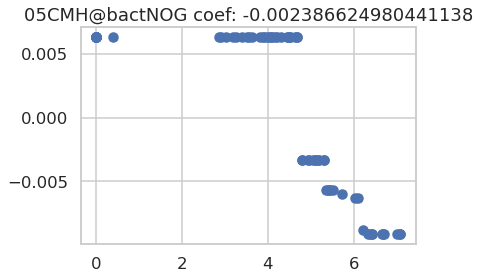

In [38]:
i = 0
col = adenoma_analysis.index[i]
plt.scatter(X_adenoma[col], explanation_df[col])
plt.title(f"{col} coef: {linregress(X_adenoma[col], explanation_df[col])[0]}")

In [89]:
from scipy import stats

small = data.loc[data.DISEASE == "Small Adenoma", "proba"]
healthy = data.loc[data.DISEASE == "healthy", "proba"]
adenoma = data.loc[data.DISEASE == "Adenoma", "proba"]

#print(stats.ttest_ind(small, healthy, equal_var=False))
#print(stats.ttest_ind(adenoma, healthy, equal_var=False))
#print(stats.ttest_ind(small, adenoma, equal_var=False))

print("H < SA")
print(stats.mannwhitneyu(healthy, small, use_continuity=True, alternative="less"))
print("H < A")
print(stats.mannwhitneyu(healthy, adenoma, use_continuity=True, alternative="less"))
print("SA < A")
print(stats.mannwhitneyu(small, adenoma, use_continuity=True, alternative="less"))

small.size, healthy.size, adenoma.size

H < SA
MannwhitneyuResult(statistic=1145.0, pvalue=0.17582648449770855)
H < A
MannwhitneyuResult(statistic=2251.0, pvalue=0.00027046544933937637)
SA < A
MannwhitneyuResult(statistic=681.0, pvalue=0.06294568618480112)


(26, 100, 66)

In [43]:
import sklearn.feature_selection as skfs
from sklearn.base import clone

def remove_healthy_batch(features, y, g, selector=skfs.SelectFdr()):
    selector = clone(selector)
    healthy_query = y == False
    features_healthy = features.loc[healthy_query, :]
    label = g[healthy_query]

    selector.fit(features_healthy, label)
    support = selector.get_support()

    features_filt = features.loc[:, ~support]

    return features_filt


def remove_iqr(features, threshold=0.0):
    from scipy.stats import iqr

    support = features.apply(iqr) > threshold

    return features.loc[:, support]

In [41]:
condition = "CRC"
profile_name = "OGs"

features, metadata = datasets.build_condition_dataset(condition, profile_name, ext="jbl")
features = datasets.filter_egg(features)


In [59]:
columns = features.columns

In [158]:
20_000

20000

In [165]:
%%capture cap_out

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from interpret.glassbox import ExplainableBoostingClassifier
from scipy import stats

query_ = metadata.DISEASE.isin([condition, "healthy"])
disease_train = metadata.DISEASE[query_]
y_ = metadata.DISEASE[query_] == condition
X_ = features.loc[query_, :]
g = metadata.loc[query_, PROJECT_COLUMN_NAME]
metadata_adenoma = metadata.loc[~query_, :].copy()

n_sel = 1_000

if profile_name != "centrifuge":
    X_ = remove_iqr(X_)
    X_ = remove_healthy_batch(X_, y_, g)
k = n_sel if n_sel < (X_.shape[1]) else X_.shape[1]
selector = skfs.SelectKBest(k=k).fit(X_, y_)
kbest = selector.get_support()

X_ = X_.loc[:, kbest].apply(np.log1p)
# X_ = features.loc[query_, columns].apply(np.log1p)
print(X_.shape)

healthy_l_small = []
healthy_l_adenoma = []
small_l_adenoma = []

n_split = 2

for i in range(n_split):
    X_train, X_val, y_train, y_val = train_test_split(X_, disease_train, test_size=0.30, random_state=i, stratify=y_)
    y_train = y_train == condition

    model = models.get_taxonomic_model(lopo=True, selector=True)
    model = ExplainableBoostingClassifier(n_estimators=32, n_jobs=-1, max_n_bins=20)
    model.fit(X_train, y_train)

    X_test = features.loc[~query_, X_.columns].apply(np.log1p)
    y_test = metadata.DISEASE[~query_]

    new_metadata = pd.concat((metadata, metadata_adenoma), axis=0)
    #new_metadata = new_metadata.loc[new_metadata.index.drop_duplicates(keep="first"), :]
    new_metadata.drop_duplicates(inplace=True)

    probas_test = model.predict_proba(X_test)[:, 1]
    probas_test = pd.Series(probas_test, index=y_test.index, name="proba")
    data_test = pd.concat((probas_test, y_test), axis=1)

    probas_val = model.predict_proba(X_val)[:, 1]
    probas_val = pd.Series(probas_val, index=y_val.index, name="proba")
    data_val = pd.concat((probas_val, y_val), axis=1)

    data = pd.concat((data_val, data_test), axis=0)
    #data = pd.concat((data, new_metadata[PROJECT_COLUMN_NAME]), axis=1, join="inner")
    data["Project"] = new_metadata.loc[data.index, PROJECT_COLUMN_NAME]

    query = data.DISEASE.str.lower().str.contains("metastases")
    data.DISEASE[query] = "Metastases"

    query = data.DISEASE.str.contains("CRC;")
    data.DISEASE[query] = "CRC + Others"

    query = data.DISEASE.str.contains("adenoma;")
    data.DISEASE[query] = "Adenoma + Others"

    query = data.DISEASE.str.lower().str.contains("small")
    data.DISEASE[query] = "Small Adenoma"

    query = data.DISEASE.str.lower().str.contains("adenoma") & ~data.DISEASE.str.lower().str.contains("small")
    data.DISEASE[query] = "Adenoma"

    query = data.DISEASE.str.contains("T2D")
    data.DISEASE[query] = "T2D + Others (non CRC)"


    small = data.loc[data.DISEASE == "Small Adenoma", "proba"]
    healthy = data.loc[data.DISEASE == "healthy", "proba"]
    adenoma = data.loc[data.DISEASE == "Adenoma", "proba"]

    #print(stats.ttest_ind(small, healthy, equal_var=False))
    #print(stats.ttest_ind(adenoma, healthy, equal_var=False))
    #print(stats.ttest_ind(small, adenoma, equal_var=False))

    healthy_l_small.append(stats.mannwhitneyu(healthy, small, use_continuity=True, alternative="less"))
    healthy_l_adenoma.append(stats.mannwhitneyu(healthy, adenoma, use_continuity=True, alternative="less"))
    small_l_adenoma.append(stats.mannwhitneyu(small, adenoma, use_continuity=True, alternative="less"))

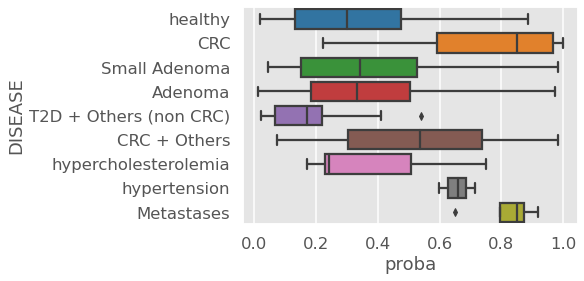

In [166]:
sns.boxplot(x="proba", y=DISEASE_COLUMN_NAME, data=data)

In [161]:
from sklearn import metrics

query = data.DISEASE.str.lower().str.contains("crc|healthy") & (~data.DISEASE.str.lower().str.contains("t2d"))
truth = data.loc[query, DISEASE_COLUMN_NAME].str.lower().str.contains("crc")
preds = data.loc[query, "proba"]
print(metrics.roc_auc_score(truth, preds))


query = data.DISEASE.str.lower().str.contains("crc|healthy") & (~data.DISEASE.str.lower().str.contains("t2d|other"))
truth = data.loc[query, DISEASE_COLUMN_NAME].str.lower().str.contains("crc")
preds = data.loc[query, "proba"]
print(metrics.roc_auc_score(truth, preds))



0.7927972027972028
0.8569072164948452


In [162]:
adenoma_mwtest = {
    "healthy_l_small": healthy_l_small,
    "healthy_l_adenoma": healthy_l_adenoma,
    "small_l_adenoma": small_l_adenoma
}

In [164]:
adenoma_mwtest

{'healthy_l_small': [MannwhitneyuResult(statistic=1111.0, pvalue=0.1279043301651181),
  MannwhitneyuResult(statistic=1098.0, pvalue=0.11223594031364431)],
 'healthy_l_adenoma': [MannwhitneyuResult(statistic=1918.0, pvalue=2.577384455987483e-06),
  MannwhitneyuResult(statistic=2370.0, pvalue=0.0010811954902407834)],
 'small_l_adenoma': [MannwhitneyuResult(statistic=631.0, pvalue=0.024760528186784706),
  MannwhitneyuResult(statistic=763.0, pvalue=0.2062649364512189)]}

Text(0.5, 1.0, 'OGs_small_l_adenoma')

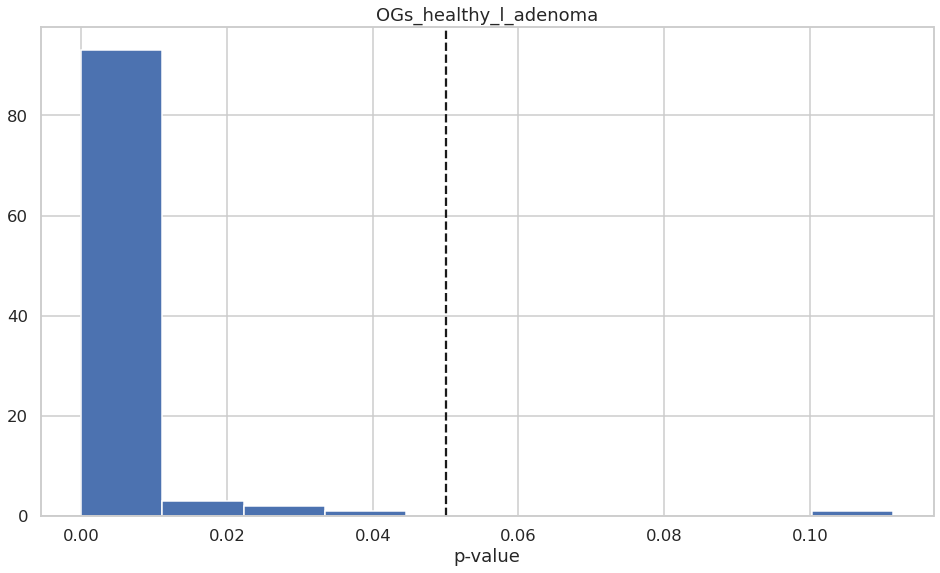

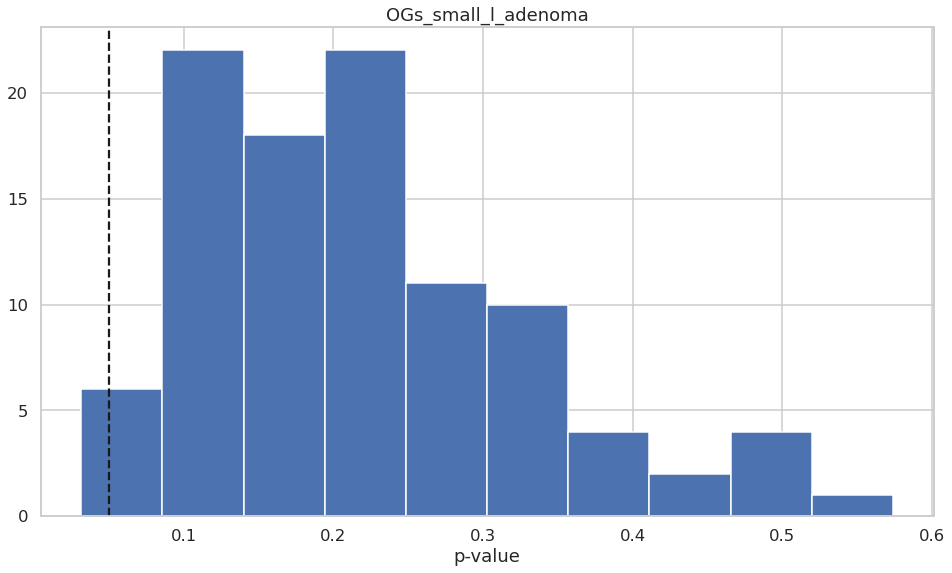

In [81]:
pvals = np.array([x[-1] for x in healthy_l_adenoma])
alpha = 0.05
plt.figure(figsize=(16,9))
plt.hist(pvals)
plt.xlabel("p-value")
plt.axvline(alpha, linestyle="--", color="k")
plt.title(f"{profile_name}_healthy_l_adenoma")

pvals = np.array([x[-1] for x in small_l_adenoma])
alpha = 0.05
plt.figure(figsize=(16,9))
plt.hist(pvals)
plt.xlabel("p-value")
plt.axvline(alpha, linestyle="--", color="k")
plt.title(f"{profile_name}_small_l_adenoma")

#plt.savefig(f"{profile_name}_pval.pdf")

In [406]:
import pathlib
import dotenv

env_file = dotenv.find_dotenv()
project_path = pathlib.Path(env_file).parent
data_path = project_path.joinpath("data")
paper_path = data_path.joinpath("paper")

In [407]:
results = {}

for profile_name in ["KEGG_KOs", "centrifuge", "OGs"]:
    name = f"{condition}_{profile_name}_adenoma_mwtest.jbl"
    path = paper_path.joinpath(f"{condition}_{profile_name}", name)
    if profile_name == "kcentrifuge":
        results[profile_name] = adenoma_mwtest
    else:
        results[profile_name] = joblib.load(path)
        

In [408]:
pd.DataFrame(results).index

Index(['healthy_l_small', 'healthy_l_adenoma', 'small_l_adenoma',
       'adenoma_l_crc'],
      dtype='object')

In [409]:
test = "healthy_l_adenoma"
dfs = []
alpha_sig = 0.05

for test in results[list(results.keys())[0]].keys():
    if test == "small_l_healthy":
        continue
    df = pd.DataFrame()
    for profile_name in results.keys():
        try:
            df[profile_name] = [x[-1] for x in results[profile_name][test]]
            df[profile_name]  = df[profile_name] < alpha_sig
        except:
            df[profile_name] = np.nan
    df["test"] = test
    dfs.append(df)

df = pd.concat(dfs, axis=0)
df

,KEGG_KOs,centrifuge,OGs,test
0,False,True,False,healthy_l_small
1,False,False,False,healthy_l_small
2,False,False,False,healthy_l_small
3,False,False,False,healthy_l_small
4,False,False,False,healthy_l_small
...,...,...,...,...
95,True,True,True,adenoma_l_crc
96,True,True,True,adenoma_l_crc
97,False,True,True,adenoma_l_crc
98,True,True,True,adenoma_l_crc


In [410]:
df = df.groupby("test").agg(sum).T.reset_index()
df["healthy_l_crc"] = 100.0
df

test,index,adenoma_l_crc,healthy_l_adenoma,healthy_l_small,small_l_adenoma,healthy_l_crc
0,KEGG_KOs,68.0,100.0,0.0,85.0,100.0
1,centrifuge,100.0,47.0,52.0,0.0,100.0
2,OGs,100.0,100.0,5.0,100.0,100.0


In [411]:
df = df.rename(
    columns={"healthy_l_adenoma": "H < A",
             "adenoma_l_crc": "A < T",
             "small_l_adenoma": "S < A",
             "healthy_l_small": "H < S",
             "healthy_l_crc": "H < T"
            })

df = df.replace({"KEGG_KOs": "Kegg", "centrifuge": "Taxo"})

# df["%AUC"] = [79, 87, 85]
df = df.rename(columns={"index": "Profile"})
df["Profile"] = df["Profile"].replace({"OGs": "eNog"})
df = df.sort_values(by="Profile")
df = df.reset_index()
df = df.drop("index", axis=1)
# df

In [412]:
df

test,Profile,A < T,H < A,H < S,S < A,H < T
0,Kegg,68.0,100.0,0.0,85.0,100.0
1,Taxo,100.0,47.0,52.0,0.0,100.0
2,eNog,100.0,100.0,5.0,100.0,100.0


[68.0, 100.0, 0.0, 85.0, 100.0, 68.0]
[100.0, 47.0, 52.0, 0.0, 100.0, 100.0]
[100.0, 100.0, 5.0, 100.0, 100.0, 100.0]


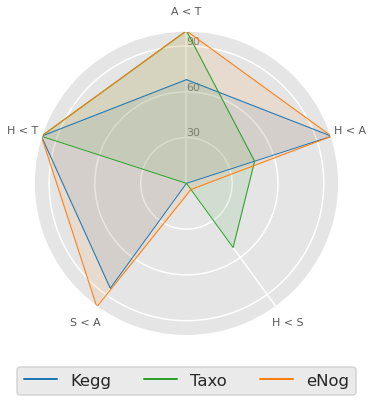

In [423]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import itertools
import matplotlib._color_data as mcd

xkcd = [mcd.XKCD_COLORS["xkcd:" + n] for n in ["lavender", "khaki", "purple"]]
tab = [mcd.TABLEAU_COLORS["tab:" + n] for n in ["blue", "green", "orange"]]


plt.style.use("ggplot")
sns.set_context("talk")
sns.set_palette("tab10")
palette = itertools.cycle(sns.color_palette("tab10"))

# Set data
 
# number of variable
categories=df.columns[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, size=11)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([30, 60, 90], ["30","60","90"], color="grey", size=11)
plt.ylim(0, 100)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

for i in range(df.shape[0]):
    values=df.loc[i].drop('Profile').values.flatten().tolist()
    values += values[:1]
    print(values)
    color = next(palette)
    color = tab[i]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.iloc[i, 0], color=color)
    ax.fill(angles, values, alpha=0.1, color=color)
    
# Add legend
leg = plt.legend(loc=8, ncol=3,  bbox_to_anchor=(0.5, -0.22))
# leg = plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1.5))
# set the linewidth of each legend object
# plt.legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
plt.tight_layout()

EXTENSIONS = ["pdf", "png", "svg"]
fig_folder_path = project_path.joinpath("data/paper/figs")
for ext in EXTENSIONS:
    fig_path = fig_folder_path.joinpath(
        f"{condition}_adenoma_radar.{ext}"
    )
    plt.savefig(fig_path, dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()
plt.close()

# Stability

In [81]:
import pathlib
import dotenv

env_file = dotenv.find_dotenv()
project_path = pathlib.Path(env_file).parent
data_path = project_path.joinpath("data")
paper_path = data_path.joinpath("paper")

profile_name = "centrifuge"
profile_folder_name = f"{condition}_{profile_name}"
fname = f"{condition}_{profile_name}_stability.jbl"
fpath = paper_path.joinpath(profile_folder_name, fname)
fpath

PosixPath('/mnt/lustre/scratch/home/cloucera/projects/babelomics/mlgut/data/paper/CRC_centrifuge/CRC_centrifuge_stability.jbl')

In [82]:
results = joblib.load(fpath)

In [8]:
project_name = list(results.keys())[1]
project_name

'PRJEB27928'

In [9]:
from mlgut.models import compute_support_ebm

coef = compute_support_ebm(results[project_name]["estimator"][0])[1]
coef.shape

/mnt/lustre/scratch/home/cloucera/projects/babelomics/mlgut/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha


(20253,)

In [10]:
features, metadata = datasets.build_condition_dataset(condition, profile_name, ext="jbl")

In [11]:
tax_id = "9606"
features = features.drop(tax_id, axis=1)

In [12]:
features.shape

(864, 20253)

In [13]:
coef = pd.Series(coef, index=features.columns)

In [14]:
coefs = [pd.Series(compute_support_ebm(r)[1], index=features.columns) for r in results[project_name]["estimator"]]

In [15]:
coefs = pd.concat(coefs, axis=1)

In [16]:
from sklearn import metrics

In [17]:
coef_filt = coefs.loc[coefs.any(axis=1), :]

In [18]:
coef_filt

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
195,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
287,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,1.003146,...,0.000000,0.000000,0.498406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
294,1.115922,0.0,0.700361,2.162137,0.948939,0.000000,2.813272,1.072878,0.5659,0.764364,...,1.199647,2.125333,0.000000,0.546458,0.954483,1.030339,1.554112,0.938535,1.070358,0.652388
358,0.000000,0.0,0.000000,0.000000,0.000000,0.508178,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
487,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585119,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2585754,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2585755,0.887574,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2585756,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.770918,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.729712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
from mlgut.models import rbo_dist

p=0.999
dmat = metrics.pairwise_distances(X=coef_filt.T, n_jobs=-1, metric=rbo_dist, p=p)

In [20]:
dmat.shape

(100, 100)

Text(0, 0.5, '$RBO_{d}$')

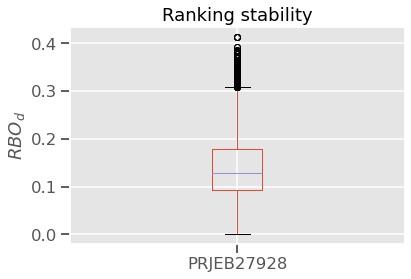

In [21]:
pd.Series(dmat.ravel(), name=project_name).plot(kind="box")
plt.title("Ranking stability")
plt.ylabel("$RBO_{d}$")

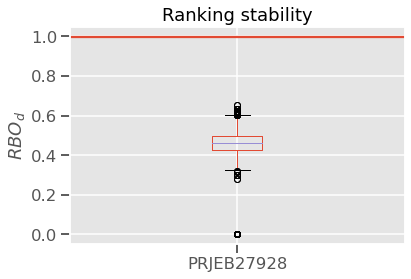

In [22]:
p = 0.99
n_features = features.shape[1]
x = np.random.permutation(n_features)
y = np.random.permutation(n_features)
baseline = rbo_dist(x, y, p=p)

dmat = metrics.pairwise_distances(X=coef_filt.T, n_jobs=-1, metric=rbo_dist, p=p)

pd.Series(dmat.ravel(), name=project_name).plot(kind="box")
plt.title("Ranking stability")
plt.ylabel("$RBO_{d}$")
plt.axhline(baseline)


In [2]:
from scipy import stats as sps
n_features = coef_filt.shape[0]
x = np.random.permutation(n_features)
y = np.random.permutation(n_features)

x = [1, 1, 0]
y = [2, 1, 1]

sps.spearmanr(x, y), sps.spearmanr(coef_filt.iloc[:, 1], coef_filt.iloc[:, 2])

NameError: name 'coef_filt' is not defined

In [36]:
def spearman_dist(x, y): 
    return 1 - sps.spearmanr(x.argsort(), y.argsort())[0]

In [37]:
spearman_dist(x, y)

0.9901861700534207

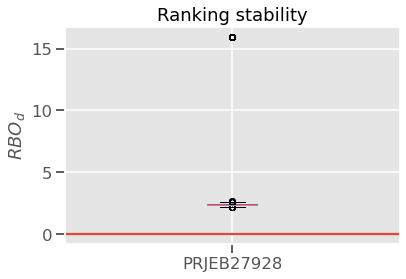

In [56]:
n_features = coef_filt.shape[0]
x = np.random.permutation(n_features)
y = np.random.permutation(n_features)
baseline = spearman_dist(x, y)

dmat_r = metrics.pairwise_distances(X=coefs.T, n_jobs=1, metric=spearman_dist)

pd.Series(dmat_r.ravel(), name=project_name).apply(lambda x: -np.log10(x)).plot(kind="box")
plt.title("Ranking stability")
plt.ylabel("$RBO_{d}$")
plt.axhline(-np.log10(baseline))

In [53]:
dmat_r.ravel()

array([1.11022302e-16, 3.71973226e-03, 3.81023296e-03, ...,
       4.18702943e-03, 4.17802144e-03, 1.11022302e-16])

In [43]:
PROJECT_NAMES_DICT = {
    "PRJNA389927": "Hannigan",
    "PRJEB12449": "Vogtmann",
    "PRJEB6070": "Zeller",
    "PRJEB7774": "Feng",
    "PRJEB10878": "Yu",
    "PRJNA447983": "Thomas0",
    "PRJEB27928": "Thomas1",
}

In [85]:
coefs_project = {PROJECT_NAMES_DICT[project_name]: [pd.Series(compute_support_ebm(r)[1], index=features.columns) for r in results[project_name]["estimator"]] for project_name in results.keys()}

In [86]:
coefs_project = {key: pd.concat(values, axis=1).T for key, values in coefs_project.items()}

In [46]:
coefs_project = {key: values.loc[values.any(axis=1), :] for key, values in coefs_project.items()}

In [ ]:
import itertools

r = {f"{x}x{y}": metrics.pairwise_distances(X=coefs_project[x], Y=coefs_project[y], n_jobs=-1, metric=spearman_dist)  for x, y in itertools.product(coefs_project.keys(), coefs_project.keys())}

In [93]:
df = {key: val.ravel() for key, val in r.items()}

In [94]:
df_plot = pd.DataFrame(df)

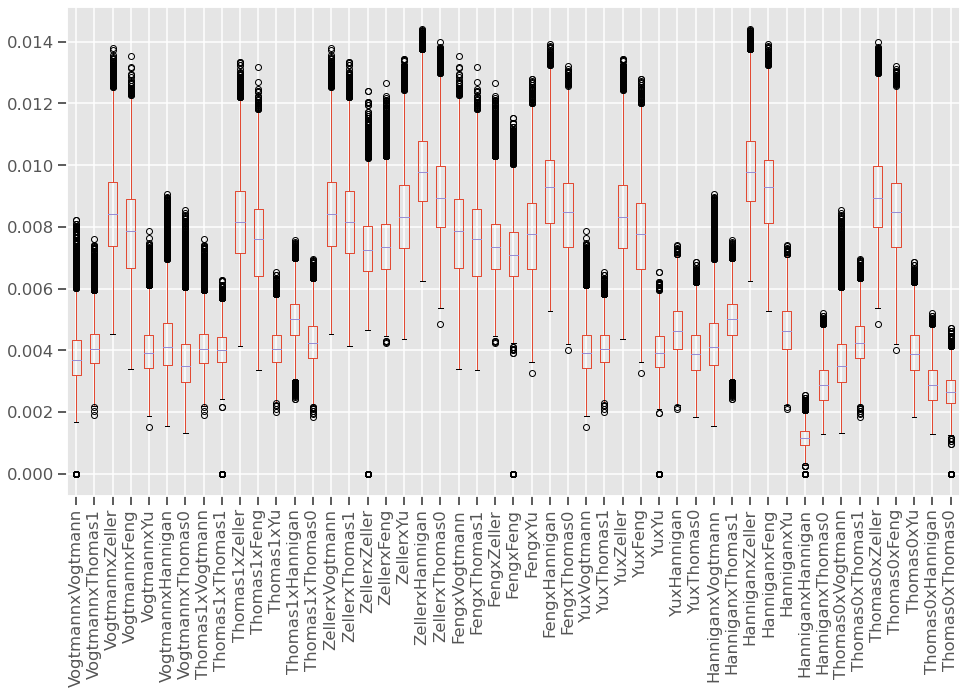

In [97]:
df_plot.plot(kind="box", rot=90, figsize=(16, 9))

In [63]:
def w_rbo(p=0.9, d=10):
    """Calculate weight of first d rankings with parameter p"""
    w = 1 - p**(d - 1) + ((1 - p) / p) * d * (np.log(1 / (1 - p)) - sum(p**i / i for i in range(1, d)))
    return w

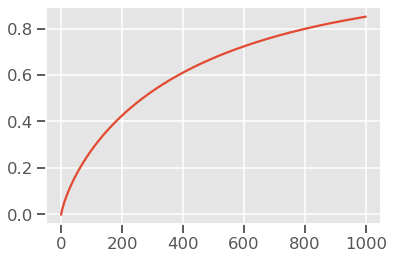

In [65]:
d = np.arange(1000)
plt.plot(d, [w_rbo(p=0.999, d=x) for x in d])

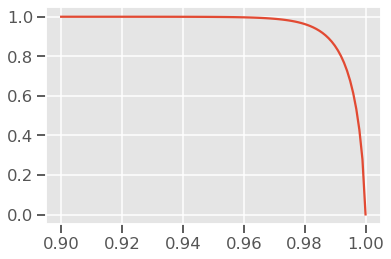

In [73]:
p = np.linspace(0.9, 1-1e-6, 100)
plt.plot(p, [w_rbo(p=x, d=100) for x in p])